# Import

In [2]:
#import initial packages

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import re
from sklearn.model_selection import train_test_split
from selenium import webdriver

# Obtain

## With Proxy - I use the markdown below when I cannot access the website

PROXY = "174.127.155.118:32505"

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--proxy-server=%s' % PROXY)

driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.whoscored.com/Regions/233/Tournaments/85/Seasons/7609/Stages/17011/PlayerStatistics/USA-Major-League-Soccer-2019")






#connect python to control browser page
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')




## Without proxy

In [662]:
#Open browser to the interactive table for MLS data
driver = webdriver.Chrome()
driver.get("https://www.whoscored.com/Regions/233/Tournaments/85/Seasons/7609/Stages/17011/PlayerStatistics/USA-Major-League-Soccer-2019")


#connect python to control browser page
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')




In [18]:
#Click "I Accept" for the pop-up

time.sleep(2)
accept = driver.find_elements_by_tag_name('button')[-1]
accept.click()
time.sleep(2)

In [20]:
#Set filters to have per 90 minutes stats and CB's only



#Click "Detailed"
driver.find_elements_by_id('detailed-statistics-tab')[0].click()
time.sleep(5)


#Change to per90
driver.find_elements_by_id('statsAccumulationType')[0].click()
time.sleep(3)
driver.find_elements_by_xpath("//*[@id='statsAccumulationType']/option[2]")[0].click()
time.sleep(3)



#Change to CB
driver.find_elements_by_id('position')[0].click()
time.sleep(5)
driver.find_elements_by_id('toggle-all-positions')[0].click()
time.sleep(3)

driver.find_elements_by_xpath('//*[@id="pitch"]/tbody/tr[5]/td[2]/label/input')[0].click()
time.sleep(3)

driver.find_elements_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button')[0].click()
time.sleep(3)

ElementClickInterceptedException: Message: element click intercepted: Element <label style="cursor: pointer" id="toggle-all-positions">...</label> is not clickable at point (174, 739). Other element would receive the click: <html lang="en">...</html>
  (Session info: chrome=76.0.3809.132)


In [561]:
#update the html
html = driver.execute_script("return document.documentElement.innerHTML;")
soup = BeautifulSoup(html, 'html.parser')

#Create a list of all the stats to save
stats_d = driver.find_elements_by_tag_name('optgroup')[0].find_elements_by_tag_name('option')
stats_o = driver.find_elements_by_tag_name('optgroup')[1].find_elements_by_tag_name('option')
stats_p = driver.find_elements_by_tag_name('optgroup')[2].find_elements_by_tag_name('option')
stats = stats_d + stats_o + stats_p

#Create a list of all the countries in the database
countries = [driver.find_elements_by_id('nationality')[0].find_elements_by_tag_name('option')[x] for x in range(1,len(driver.find_elements_by_id('nationality')[0].find_elements_by_tag_name('option')))]

In [392]:
#Create dictionary for data storage
statistics = {}

In [393]:
for country in countries[-2:]:

    #Clear age option
    driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[1]').click()
    time.sleep(3)

    #Click on new country
    country.click()
    time.sleep(3)

    #Click Search
    driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
    time.sleep(3)

    html = driver.execute_script("return document.documentElement.innerHTML;")
    soup = BeautifulSoup(html, 'html.parser')


    entries = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('td')
    num_players_in_table = str(entries).count('player-link') #number of players in table

    
    #go to the next country if there are no CB's in MLS from the currrent coutnry
    if num_players_in_table <= 0:
        continue


    else:
        
        #find the ages of the players who appear in the table
        table_ages = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('span', class_ = 'player-meta-data')  

        ages_to_input = []

        for table_age in table_ages:
            try:
                ages_to_input.append(int(table_age.text))
            except:
                continue

        ages_to_input = list(sorted(list(set(ages_to_input))))
        
        #filter the table by the age of each player saved before
        for age in ages_to_input:
            #Click Equals
            driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[2]').click()
            time.sleep(2)


            #Clear Age
            driver.find_element_by_xpath('//*[@id="age"]').clear()
            time.sleep(2)

            #Fill in Age
            driver.find_element_by_xpath('//*[@id="age"]').send_keys(str(age))
            time.sleep(2)


            #Click Search
            driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
            time.sleep(2)


            #iterate through all stats and save them and player info in the statistics dictionary
            for stat in stats:
                stat.click()
                time.sleep(2)
                html = driver.execute_script("return document.documentElement.innerHTML;")
                soup = BeautifulSoup(html, 'html.parser')  

                for row in soup.findAll('tbody', id = "player-table-statistics-body")[1:]:
                    info = row.findAll('td')
                    info_length = len(info)
                    num_players_in_table = str(info).count('player-link') #number of players in table



                    if num_players_in_table == 1:

                        name = info[2].findAll(class_ = 'player-link')[0].text
                        names = list(statistics.keys())
                        if name not in names:
                            statistics[name] = {}
                            statistics[name]['team'] = info[2].findAll(class_ = 'team-name')[0].text
                            statistics[name]['appearances'] = float(info[3].text)
                            statistics[name]['mins'] = float(info[4].text)
                            statistics[name]['rating'] = float(info[-1].text)





                        for stat in info[5:-1]:
                            try:
                                statistics[name][stat['class'][0]] = float(stat.text)
                            except:
                                statistics[name][stat['class'][0]] = 0




                    #Adjust code to handle table results with more than one player
                    else:
                        time.sleep(3)
                        num_players_in_table = str(info).count('player-link') #number of players in table
                        time.sleep(3)
                        items_per_player = round(info_length / num_players_in_table)
                        
                        
                        #divide the results into chunks that represent each player
                        chunks  = []
                        for i in range(num_players_in_table):
                            chunk = []
                            index = i * items_per_player
                            for x in range(items_per_player):
                                chunk.append(info[index])
                                index += 1
                                chunks.append(chunk)

                        #repeat process for player info and stats storage
                        for chunk in chunks:
                            name = chunk[2].findAll(class_ = 'player-link')[0].text
                            names = list(statistics.keys())
                            if name not in names:
                                statistics[name] = {}
                                statistics[name]['team'] = chunk[2].findAll(class_ = 'team-name')[0].text
                                statistics[name]['appearances'] = float(chunk[3].text)
                                statistics[name]['mins'] = float(chunk[4].text)
                                statistics[name]['rating'] = float(chunk[-1].text)
                            for stat in chunk[5:-1]:
                                try:
                                    statistics[name][stat['class'][0]] = float(stat.text)
                                except:
                                    statistics[name][stat['class'][0]] = 0
    print (list(statistics.keys()))
    print(len(list(statistics.keys())))
    print()


['Miles Robinson ', 'Sean Nealis ', 'Justen Glad ', 'Kamal Miller ', 'Tristan Blackmon ', 'Graham Smith ', 'Brandon Bye ', 'Grant Lillard ', 'Keegan Rosenberry ', 'Jalen Robinson ', 'Alex Crognale ', 'Forrest Lasso ', 'Walker Zimmerman ', 'Aaron Long ', 'Nick Hagglund ', "Shane O'Neill ", 'Dave Romney ', 'Tim Parker ', 'Jonathan Campbell ', 'Tony Rocha ', 'Steven Birnbaum ', 'Daniel Steres ', 'Brent Kallman ', 'Ryan Hollingshead ', 'Alex De John ', 'Ben Sweat ', 'Kofi Opare ', 'Ike Opara ', 'Omar González ', 'Jalil Anibaba ', 'Chad Marshall ', 'Michael Parkhurst ', 'Drew Moor ']
33

['Miles Robinson ', 'Sean Nealis ', 'Justen Glad ', 'Kamal Miller ', 'Tristan Blackmon ', 'Graham Smith ', 'Brandon Bye ', 'Grant Lillard ', 'Keegan Rosenberry ', 'Jalen Robinson ', 'Alex Crognale ', 'Forrest Lasso ', 'Walker Zimmerman ', 'Aaron Long ', 'Nick Hagglund ', "Shane O'Neill ", 'Dave Romney ', 'Tim Parker ', 'Jonathan Campbell ', 'Tony Rocha ', 'Steven Birnbaum ', 'Daniel Steres ', 'Brent Kallman

In [ ]:
#Create and save dataframe derived from statistics dictionary

df = pd.DataFrame(statistics).T
df.to_csv('cb_stats_final.csv')

In [4]:
#Load and reindex in database

df = pd.read_csv('cb_stats_final.csv')
new_cols = list(df.columns)
new_cols[0] = 'name'
df = pd.read_csv('cb_stats_final.csv', names = new_cols)
df = df.drop([0], axis = 0)
df = df.reset_index(drop=True)
df

,name,appearances,assist,assistCorner,assistCross,assistFreekick,assistOther,assistThroughball,assistThrowin,challengeLost,...,shortPassInaccurate,shotOboxTotal,shotPenaltyArea,shotSixYardBox,shotsTotal,tackleTotalAttempted,tackleWonTotal,team,turnover,yellowCard
0,Franco Escobar,4,0,0,0,0,0,0,0,0.5,...,6.5,0,0.3,0.3,0.5,3,2.5,"Atlanta United,",1,0
1,Víctor Cabrera,12,0,0,0,0,0,0,0,1.8,...,4.4,0.2,0.4,0,0.6,5.1,3.4,"Montreal Impact,",0.8,0.2
2,Erik Godoy,26,0,0,0,0,0,0,0,0.3,...,3.5,0.1,0.3,0,0.4,1.8,1.5,"Vancouver Whitecaps,",0.3,0.2
3,Leandro González Pirez,26,0,0,0,0,0,0,0,0.8,...,5.2,0.2,0.5,0,0.7,3.2,2.4,"Atlanta United,",0.7,0.4
4,Gastón Sauro,15,0,0,0,0,0,0,0,0.2,...,2.9,0,0.4,0.4,0.8,1.9,1.7,"Columbus Crew,",0.4,0.3
5,Laurent Ciman,13,0,0,0,0,0,0,0,1.3,...,2.9,0.4,0.4,0,0.8,2.6,1.3,"Toronto FC,",0.2,0.2
6,Auro,1,1,0,1,0,0,0,0,1,...,2,0,0,0,0,1,0,"Toronto FC,",1,0
7,Bressan,6,0,0,0,0,0,0,0,1.2,...,4.8,0,0.5,0,0.5,4.9,3.7,"FC Dallas,",0.5,0.2
8,Marcelo Silva,12,0,0,0,0,0,0,0,0.6,...,3.8,0,0.4,0.1,0.5,1.6,1,"Real Salt Lake,",0.3,0.1
9,Marcelo,11,0,0,0,0,0,0,0,1,...,4.6,0,0.4,0.1,0.5,3.3,2.3,"Chicago Fire,",0.5,0.1


# Find ages for each name

In [5]:
#I scraped through again in a similar fashion to above to make sure the player names and ages were correct and in my database


NAMES = []
AGES = []

for country in countries:

    #Clear age option
    driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[1]').click()
    time.sleep(3)

    #Click on new country
    country.click()
    time.sleep(3)

    #Click Search
    driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
    time.sleep(3)

    html = driver.execute_script("return document.documentElement.innerHTML;")
    soup = BeautifulSoup(html, 'html.parser')


    entries = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('td')
    num_players_in_table = str(entries).count('player-link') #number of players in table


    if num_players_in_table <= 0:
        continue


    else:

        table_ages = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('span', class_ = 'player-meta-data')  

        ages_to_input = []

        for table_age in table_ages:
            try:
                ages_to_input.append(int(table_age.text))
            except:
                continue

        ages_to_input = list(sorted(list(set(ages_to_input))))

        for age in ages_to_input:
            #Click Equals
            driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[2]').click()
            time.sleep(2)


            #Clear Age
            driver.find_element_by_xpath('//*[@id="age"]').clear()
            time.sleep(2)

            #Fill in Age
            driver.find_element_by_xpath('//*[@id="age"]').send_keys(str(age))
            time.sleep(2)


            #Click Search
            driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
            time.sleep(2)


            html = driver.execute_script("return document.documentElement.innerHTML;")
            soup = BeautifulSoup(html, 'html.parser')

            player_names = [x.text for x in soup.findAll('div', id = 'statistics-table-detailed')[0].findAll('a', class_ = 'player-link')]

            for name in player_names:
                NAMES.append(name)


            table_items = soup.findAll('tbody', id = 'player-table-statistics-body')[1].findAll('td', class_ = 'pn')
            for index in range(len(table_items)):
                AGES.append(table_items[index].findNext('span', class_ = 'player-meta-data').text)



name_dict = {}
name_dict['NAMES'] = NAMES

ages_edited = []
for age in AGES:
    ages_edited.append(int(age))


name_dict['AGES'] = ages_edited
ages_df = pd.DataFrame(name_dict)


NameError: name 'countries' is not defined

# Find missing (name, country) pairings

In [29]:
#Players are missing - scroll through to see from which countries the missing players are
#Repeat prior scraping process saving information for nationality, name, and age

names_in_df = list(df['name'])
counter = 0
country_names = [x.text for x in soup.findAll('select', id = 'nationality')[0].findAll('option')][1:]
all_names = []

for country in countries:
    
    #Clear age option
    driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[1]').click()
    time.sleep(3)

    #Click on new country
    country.click()
    time.sleep(3)

    #Click Search
    driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
    time.sleep(3)

    html = driver.execute_script("return document.documentElement.innerHTML;")
    soup = BeautifulSoup(html, 'html.parser')


    entries = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('td')
    num_players_in_table = str(entries).count('player-link') #number of players in table


    if num_players_in_table <= 0:
        counter += 1
        continue
    else:
        #Get total number of players for country
        
        num_players_for_country = int(soup.findAll(class_ = 'listbox right')[1].findAll('b')[0].text[-2:])
        country_name = country_names[counter]
        player_names = [x.text for x in soup.findAll('div', id = 'statistics-table-detailed')[0].findAll('a', class_ = 'player-link')]
        
        print('num_players_for_country: {}'.format(num_players_for_country))
        print('country_name: {}'.format(country_name))
        print('player_names: {}'.format(player_names))
        print()
        
        for player in player_names:
            all_names.append(player)
        
        counter += 1

for name in all_names:
    if name not in names_in_df:
        print(name)

num_players_for_country: 5
country_name: Argentina
player_names: ['Leandro González Pirez ', 'Víctor Cabrera ', 'Franco Escobar ', 'Gastón Sauro ', 'Erik Godoy ']

num_players_for_country: 1
country_name: Belgium
player_names: ['Laurent Ciman ']

num_players_for_country: 5
country_name: Brazil
player_names: ['Auro ', 'Bressan ', 'Danilo Silva ', 'Marcelo Silva ', 'Marcelo ']

num_players_for_country: 5
country_name: Canada
player_names: ['Dejan Jakovic ', 'Richie Laryea ', 'Doneil Henry ', 'Liam Fraser ', 'Ashtone Morgan ']

num_players_for_country: 1
country_name: Colombia
player_names: ['Eddie Segura ']

num_players_for_country: 2
country_name: DR Congo
player_names: ['Chris Mavinga ', 'Larrys Mabiala ']

num_players_for_country: 5
country_name: Costa Rica
player_names: ['Joseph Mora ', 'Francisco Calvo ', 'Kendall Waston ', 'Julio Cascante ', 'Giancarlo González ']

num_players_for_country: 1
country_name: Ecuador
player_names: ['Xavier Arreaga ']

num_players_for_country: 1
country

In [33]:
#Look up USA online and click on ages of players

usa_ages = [19, 20, 21, 27, 29, 31, 32, 36]

In [ ]:
'19': 'James Sands'
'20': 'Mark McKenzie'
'21': 'Auston Trusty'
'27': 'Andrew Farrell', 'Eriq Zavaleta', 'Saad Abdul-Salaam'
'29': 'Connor Lade', 'Kevin Garcia', 'Matt Hedges'
'31': 'Josh Williams'
'32': 'Matt Besler'
'36': 'Jeff Larentowicz'

In [34]:
statistics = {}

In [35]:
#scrape through usa players only and create new dataframe with their info and stats

for country in countries[-2:]:

    #Clear age option
    driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[1]').click()
    time.sleep(3)

    #Click on new country
    country.click()
    time.sleep(3)

    #Click Search
    driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
    time.sleep(3)

    html = driver.execute_script("return document.documentElement.innerHTML;")
    soup = BeautifulSoup(html, 'html.parser')


    entries = soup.findAll('tbody', id = "player-table-statistics-body")[1:][0].findAll('td')
    num_players_in_table = str(entries).count('player-link') #number of players in table


    if num_players_in_table <= 0:
        continue


    else:

        ages_to_input = usa_ages

        for age in ages_to_input:
            #Click Equals
            driver.find_element_by_xpath('//*[@id="ageComparisonType"]/option[2]').click()
            time.sleep(2)


            #Clear Age
            driver.find_element_by_xpath('//*[@id="age"]').clear()
            time.sleep(2)

            #Fill in Age
            driver.find_element_by_xpath('//*[@id="age"]').send_keys(str(age))
            time.sleep(2)


            #Click Search
            driver.find_element_by_xpath('//*[@id="filter-options"]/div[2]/dl/dd[4]/button').click()
            time.sleep(2)



            for stat in stats:
                stat.click()
                time.sleep(2)
                html = driver.execute_script("return document.documentElement.innerHTML;")
                soup = BeautifulSoup(html, 'html.parser')  

                for row in soup.findAll('tbody', id = "player-table-statistics-body")[1:]:
                    info = row.findAll('td')
                    info_length = len(info)
                    num_players_in_table = str(info).count('player-link') #number of players in table



                    if num_players_in_table == 1:

                        name = info[2].findAll(class_ = 'player-link')[0].text
                        names = list(statistics.keys())
                        if name not in names:
                            statistics[name] = {}
                            statistics[name]['team'] = info[2].findAll(class_ = 'team-name')[0].text
                            statistics[name]['appearances'] = float(info[3].text)
                            statistics[name]['mins'] = float(info[4].text)
                            statistics[name]['rating'] = float(info[-1].text)





                        for stat in info[5:-1]:
                            try:
                                statistics[name][stat['class'][0]] = float(stat.text)
                            except:
                                statistics[name][stat['class'][0]] = 0





                    else:
                        time.sleep(3)
                        num_players_in_table = str(info).count('player-link') #number of players in table
                        time.sleep(3)
                        items_per_player = round(info_length / num_players_in_table)
                        
                        
                        
                        chunks  = []
                        for i in range(num_players_in_table):
                            chunk = []
                            index = i * items_per_player
                            for x in range(items_per_player):
                                chunk.append(info[index])
                                index += 1
                                chunks.append(chunk)


                        for chunk in chunks:
                            name = chunk[2].findAll(class_ = 'player-link')[0].text
                            names = list(statistics.keys())
                            if name not in names:
                                statistics[name] = {}
                                statistics[name]['team'] = chunk[2].findAll(class_ = 'team-name')[0].text
                                statistics[name]['appearances'] = float(chunk[3].text)
                                statistics[name]['mins'] = float(chunk[4].text)
                                statistics[name]['rating'] = float(chunk[-1].text)
                            for stat in chunk[5:-1]:
                                try:
                                    statistics[name][stat['class'][0]] = float(stat.text)
                                except:
                                    statistics[name][stat['class'][0]] = 0
    print (list(statistics.keys()))
    print(len(list(statistics.keys())))
    print()


['James Sands ', 'Mark McKenzie ', 'Auston Trusty ', 'Andrew Farrell ', 'Eriq Zavaleta ', 'Saad Abdul-Salaam ', 'Matt Hedges ', 'Kevin Garcia ', 'Connor Lade ', 'Josh Williams ', 'Matt Besler ', 'Jeff Larentowicz ']
12



ZeroDivisionError: division by zero

In [49]:
#I manually downloaded the dataframe with just us information and 
#isolated the usa players who ere not yet in the primary dataset

df_missing

,Unnamed: 0,appearances,assist,assistCorner,assistCross,assistFreekick,assistOther,assistThroughball,assistThrowin,challengeLost,...,shortPassInaccurate,shotOboxTotal,shotPenaltyArea,shotSixYardBox,shotsTotal,tackleTotalAttempted,tackleWonTotal,team,turnover,yellowCard
0,James Sands,13.0,0,0,0,0,0,0,0,0.2,...,4.7,0.0,0.0,0.0,0.0,1.7,1.5,"New York City FC,",0.7,0.2
1,Mark McKenzie,2.0,0,0,0,0,0,0,0,0.0,...,4.5,0.0,0.0,0.0,0.0,3.0,3.0,"Philadelphia Union,",0.0,0.0
2,Auston Trusty,22.0,0,0,0,0,0,0,0,0.5,...,4.3,0.1,0.2,0.2,0.5,3.3,2.8,"Philadelphia Union,",1.0,0.1
3,Andrew Farrell,18.0,0,0,0,0,0,0,0,1.2,...,3.7,0.0,0.0,0.0,0.0,2.3,1.2,"New England Revolution,",0.4,0.3
4,Eriq Zavaleta,11.0,0,0,0,0,0,0,0,0.6,...,2.6,0.0,0.5,0.0,0.5,2.6,2.0,"Toronto FC,",0.3,0.1
5,Saad Abdul-Salaam,3.0,0,0,0,0,0,0,0,0.7,...,5.3,0.0,0.0,0.0,0.0,1.0,0.3,"Seattle Sounders FC,",1.0,0.0
6,Matt Hedges,28.0,0,0,0,0,0,0,0,0.5,...,4.0,0.0,0.3,0.0,0.3,1.8,1.3,"FC Dallas,",0.4,0.2
7,Kevin Garcia,5.0,0,0,0,0,0,0,0,0.4,...,4.0,0.0,0.2,0.0,0.2,1.0,0.6,"Houston Dynamo,",0.2,0.0
8,Connor Lade,1.0,0,0,0,0,0,0,0,1.0,...,5.0,0.0,0.0,0.0,0.0,1.0,0.0,"New York Red Bulls,",0.0,0.0
9,Josh Williams,10.0,0,0,0,0,0,0,0,0.1,...,2.8,0.0,0.3,0.0,0.3,1.3,1.2,"Columbus Crew,",0.4,0.2


In [69]:
#add missing players to the primary database


df_missing = pd.read_csv('cb_stats_usa.csv')
new_cols = list(df_missing.columns)
new_cols[0] = 'name'
df_missing.columns = new_cols
df_missing = df_missing.drop([0], axis = 0)
df_missing = df_missing.reset_index(drop=True)
df = pd.concat([df,df_missing], axis =1)

In [76]:
#Save database with all MLS Cb's
df = pd.read_csv('cb_stats_final.csv')

In [77]:
df

,Unnamed: 0,team,appearances,assist,assistCorner,assistCross,assistFreekick,assistOther,assistThroughball,assistThrowin,...,shortPassAccurate,shortPassInaccurate,shotOboxTotal,shotPenaltyArea,shotSixYardBox,shotsTotal,tackleTotalAttempted,tackleWonTotal,turnover,yellowCard
0,Franco Escobar,"Atlanta United,",4,0.0,0,0.0,0,0.0,0.0,0,...,39.0,6.5,0.0,0.3,0.3,0.5,3.0,2.5,1.0,0.0
1,Víctor Cabrera,"Montreal Impact,",12,0.0,0,0.0,0,0.0,0.0,0,...,47.1,4.4,0.2,0.4,0.0,0.6,5.1,3.4,0.8,0.2
2,Erik Godoy,"Vancouver Whitecaps,",26,0.0,0,0.0,0,0.0,0.0,0,...,34.0,3.5,0.1,0.3,0.0,0.4,1.8,1.5,0.3,0.2
3,Leandro González Pirez,"Atlanta United,",26,0.0,0,0.0,0,0.0,0.0,0,...,48.9,5.2,0.2,0.5,0.0,0.7,3.2,2.4,0.7,0.4
4,Gastón Sauro,"Columbus Crew,",15,0.0,0,0.0,0,0.0,0.0,0,...,38.2,2.9,0.0,0.4,0.4,0.8,1.9,1.7,0.4,0.3
5,Laurent Ciman,"Toronto FC,",13,0.0,0,0.0,0,0.0,0.0,0,...,42.5,2.9,0.4,0.4,0.0,0.8,2.6,1.3,0.2,0.2
6,Auro,"Toronto FC,",1,1.0,0,1.0,0,0.0,0.0,0,...,47.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,Bressan,"FC Dallas,",6,0.0,0,0.0,0,0.0,0.0,0,...,43.5,4.8,0.0,0.5,0.0,0.5,4.9,3.7,0.5,0.2
8,Marcelo Silva,"Real Salt Lake,",12,0.0,0,0.0,0,0.0,0.0,0,...,31.1,3.8,0.0,0.4,0.1,0.5,1.6,1.0,0.3,0.1
9,Marcelo,"Chicago Fire,",11,0.0,0,0.0,0,0.0,0.0,0,...,32.2,4.6,0.0,0.4,0.1,0.5,3.3,2.3,0.5,0.1


# Scrubbing and transforming

In [409]:
#Upload database
df = pd.read_csv('cb_stats_final.csv')

In [410]:
#Fill nulls with 0
df = df.fillna(0)

In [412]:
#Turn quant columns to floats

for column in ['assist', 'assistCorner', 'assistCross',
       'assistFreekick', 'assistOther', 'assistThroughball', 'assistThrowin',
       'challengeLost', 'clearanceTotal', 'dispossessed', 'dribbleLost',
       'dribbleTotal', 'dribbleWon', 'duelAerialLost', 'duelAerialTotal',
       'duelAerialWon', 'foulCommitted', 'foulGiven', 'goalObox',
       'goalPenaltyArea', 'goalSixYardBox', 'goalTotal', 'interceptionAll',
       'keyPassLong', 'keyPassShort', 'keyPassesTotal', 'offsideGiven',
       'outfielderBlock', 'outfielderBlockedPass', 'passCrossBlockedDefensive',
       'passLongBallAccurate', 'passLongBallInaccurate', 'passTotal', 'rating',
       'redCard', 'saveObox', 'savePenaltyArea', 'saveSixYardBox', 'saveTotal',
       'shortPassAccurate', 'shortPassInaccurate', 'shotOboxTotal',
       'shotPenaltyArea', 'shotSixYardBox', 'shotsTotal',
       'tackleTotalAttempted', 'tackleWonTotal', 'turnover',
       'yellowCard']:
    print(column)
    col_items = df[column]
    for index in range(len(col_items)):
        col_items[index] = float(col_items[index])
    df[column] = col_items

assist


/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assistCorner
assistCross
assistFreekick
assistOther
assistThroughball
assistThrowin
challengeLost
clearanceTotal
dispossessed
dribbleLost
dribbleTotal
dribbleWon
duelAerialLost
duelAerialTotal
duelAerialWon
foulCommitted
foulGiven
goalObox
goalPenaltyArea
goalSixYardBox
goalTotal
interceptionAll
keyPassLong
keyPassShort
keyPassesTotal
offsideGiven
outfielderBlock
outfielderBlockedPass
passCrossBlockedDefensive
passLongBallAccurate
passLongBallInaccurate
passTotal
rating
redCard
saveObox
savePenaltyArea
saveSixYardBox
saveTotal
shortPassAccurate
shortPassInaccurate
shotOboxTotal
shotPenaltyArea
shotSixYardBox
shotsTotal
tackleTotalAttempted
tackleWonTotal
turnover
yellowCard


In [413]:
#change minutes type to integer

minutes = df['mins']
for index in range(len(minutes)):
    minutes[index] = int(minutes[index])
df['mins'] = minutes

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [414]:
#Create metric for dribble success percentage

dribble_percentage = []
for index in range(len(df)):
    try:
        dribble_percentage.append(df['dribbleWon'][index] / df['dribbleTotal'][index])
    except:
        dribble_percentage.append(0)
df['dribblePercentage'] = dribble_percentage

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [415]:
#Create metric for aerial duel success percentage

duel_aerial_percentage = []
for index in range(len(df)):
    try:
        duel_aerial_percentage.append(df['duelAerialWon'][index] / df['duelAerialTotal'][index])
    except:
        duel_aerial_percentage.append(0)
df['duelAerialPercentage'] = duel_aerial_percentage

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [416]:
#Create metric for long pass success percentage

long_ball_percentage = []
for index in range(len(df)):
    try:
        long_ball_percentage.append(df['passLongBallAccurate'][index] / (df['passLongBallAccurate'][index] + df['passLongBallInaccurate'][index]))
    except:
        long_ball_percentage.append(0)
df['passLongBallPercentage'] = long_ball_percentage

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [417]:
#Create metric for short pass success percentage

short_ball_percentage = []
for index in range(len(df)):
    try:
        short_ball_percentage.append(df['shortPassAccurate'][index]/(df['shortPassAccurate'][index] + df['shortPassInaccurate'][index]))
    except:
        short_ball_percentage.append(0)
df['shortPassPercentage'] = short_ball_percentage

In [418]:
#Create metric for tackle success percentage

tackle_percentage = []
for index in range(len(df)):
    try:
        tackle_percentage.append(df['tackleWonTotal'][index] / df['tackleTotalAttempted'][index])
    except:
        tackle_percentage.append(0)
df['tacklePercentage'] = tackle_percentage

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [454]:
#create new DataFrame that filters out players with fewere than 500 minutes played


df_500 = df[df['mins'] > 500]
df_500 = df_500.reset_index(drop=True)
df_500 = df_500.fillna(0)
df_500.head()
df_500.isna().sum().sum()

0

In [22]:
from scipy.stats import rankdata

#write a function to calculate the percentiles rankings for each statistical category

def calculate_percentile(series_, method='min'):
    if isinstance(series_, list):
        series_ = np.asarray(series_)
    return rankdata(series_, method=method) / float(len(series_))



In [687]:


#Calculate the percentile ranks for each stat and add a new column for each percentile ranking
col_names = list(df_500.columns)
percentile_dict = {}
for col in col_names:
    percentile_column_name = col + '_percentile'
    try:
        percentile_dict[percentile_column_name] = np.round(calculate_percentile(df_500[col]),3)
    except:
        continue
percentile_df = pd.DataFrame(percentile_dict)

#Drop qualitative percentile columns
percentile_df = percentile_df.drop(['name_percentile', 'appearances_percentile', 'team_percentile', 'mins_percentile', 'rating_percentile'], axis = 1)

#invert the percentiles for statistics that are better if they are lower
#i.e. - you want fewer turnovers given up


percentile_df['dispossessed_percentile'] = 1 - percentile_df['dispossessed_percentile']
percentile_df['turnover_percentile'] = 1 - percentile_df['turnover_percentile']
percentile_df['foulCommitted_percentile'] = 1 - percentile_df['foulCommitted_percentile']
percentile_df['redCard_percentile'] = 1 - percentile_df['redCard_percentile']


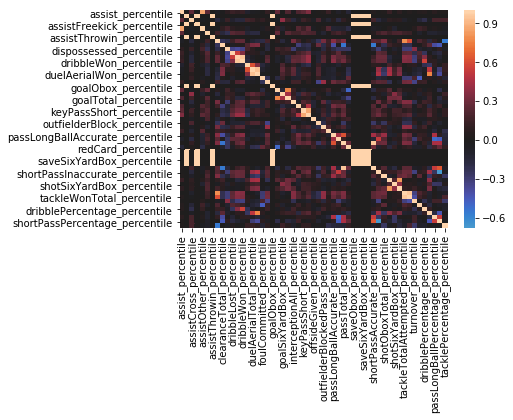

In [688]:
import seaborn as sns

#Check colinearity heat map
sns.heatmap(percentile_df.corr(), center=0);
#need less colinearity

In [689]:
#Check for colinearity numerically using .75 as a cutoff

def collinearity_dict(dataframe):
    df = dataframe
    collinearity = {}

    for col_index in range(len(df.columns)):
        too_high = []
        for row_index in range(len(df.columns)):
            if col_index != row_index:
                if (abs(df.corr()) > .75).iloc[col_index][row_index] == True:
                     too_high.append([df.columns[row_index]])
        collinearity[df.columns[col_index]] = too_high
    
    return collinearity

In [ ]:
#check dictionary of colinearity overlap amongst the percentile metrics
collinearity_dict(percentile_df)

In [690]:
#drop columns to reduce multicolinearity
percentile_df_edited = percentile_df.drop(['assistOther_percentile', 
                                           'saveObox_percentile',
                                           'savePenaltyArea_percentile',
                                           'saveSixYardBox_percentile',
                                           'saveTotal_percentile',
                                           'assistCorner_percentile',
                                           'assistThrowin_percentile',
                                           'challengeLost_percentile',
                                           'dribbleTotal_percentile',
                                           'duelAerialTotal_percentile',
                                           'goalTotal_percentile',
                                           'keyPassesTotal_percentile',
                                           'passTotal_percentile',
                                           'shotPenaltyArea_percentile',
                                           'tackleTotalAttempted_percentile',
                                            'assistFreekick_percentile'], axis = 1)

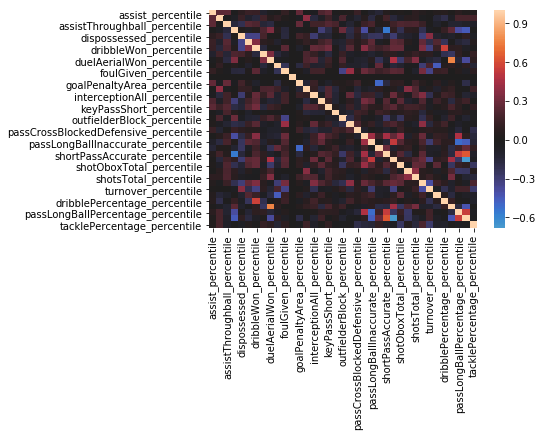

In [691]:
#Confirm visually that multicolinearity is fixed
sns.heatmap(percentile_df_edited.corr(), center=0);

In [692]:
#combine dataframe with counting stats with the df with percentile rankings

df_1 = pd.concat([df_500, percentile_df_edited], axis = 1)
df_1.to_csv('df_1.csv')

In [12]:
#save df_1

df_1 = pd._csv('df_1.csv')

# Add in ages

In [696]:
#Add ages to df_1 from previously stored ages df

ages_to_insert = []

for name_index in range(len(df_1.name)):
    try:
        ages_to_insert.append(list(ages_df[ages_df.NAMES == df_1.name[name_index]]['AGES'])[0])
    except:
        ages_to_insert.append('MISSING')

df_1['age'] = ages_to_insert

In [697]:
#Check for remaining missing ages
list(ages_df[ages_df.NAMES == df_1.name[0]]['AGES'])[0]

26

In [698]:
#Find indices that have missing age
df_1[df_1.age == 'MISSING'][['name', 'age']]

,name,age
5,Bressan,MISSING
20,Michael Mancienne,MISSING
75,James Sands,MISSING
76,Auston Trusty,MISSING
77,Andrew Farrell,MISSING
78,Eriq Zavaleta,MISSING
79,Matt Hedges,MISSING
80,Josh Williams,MISSING
81,Matt Besler,MISSING


In [700]:
#original ages df didn't account for the ages of the missing usa players, so I put them in manually

'19': 'James Sands'
'20': 'Mark McKenzie'
'21': 'Auston Trusty'
'27': 'Andrew Farrell', 'Eriq Zavaleta', 'Saad Abdul-Salaam'
'29': 'Connor Lade', 'Kevin Garcia', 'Matt Hedges'
'31': 'Josh Williams'
'32': 'Matt Besler'
'36': 'Jeff Larentowicz'

SyntaxError: invalid syntax (<ipython-input-700-3680a75c4d25>, line 4)

In [701]:
#Input missing ages
new_ages = df_1.age

new_ages[5] = 26
new_ages[20] = 31
new_ages[75] = 19
new_ages[76] = 21
new_ages[77] = 27
new_ages[78] = 27
new_ages[79] = 29
new_ages[80] = 31
new_ages[81] = 32

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is s

In [702]:
#replace column with missing ages with column that has all ages
df_1.ages = new_ages

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [703]:
#Confirm df has age for each player
df_1[df_1.age == 'MISSING'][['name', 'age']]

,name,age


In [ ]:
#Save df_1 with all ages
df_1.to_csv('df_1.csv')

# Calculate Average of Percenitle Categories and transform into rating metric


In [16]:
#Upload df_1
df_1 = pd.read_csv('df_1.csv')

In [20]:
#Calculate the average of relevant (to CB) percentile columns

top_percentile_averages = []
for index in range(len(df_1)):
    row = df_1.iloc[index]
    percentile_average = np.mean([row['duelAerialPercentage_percentile'], 
                                      row['passLongBallPercentage_percentile'], 
                                      row['interceptionAll_percentile'],
                                      row['tacklePercentage_percentile'],
                                      row['shortPassPercentage_percentile'],
                                      row['turnover_percentile'],
                                      row['dispossessed_percentile'],
                                      row['outfielderBlock_percentile'],
                                      row['outfielderBlockedPass_percentile'],
                                      row['foulCommitted_percentile'],
                                      row['tackleWonTotal_percentile'],
                                      row['duelAerialWon_percentile'],
                                      row['passLongBallAccurate_percentile'],
                                      row['shortPassAccurate_percentile'],
                                  
                                  
                                  
                                  
                                     ])
    top_percentile_averages.append(percentile_average)
df_1['top_percentile_average'] = np.round(top_percentile_averages, 3)





In [23]:
#take the perecentile rank of this average to get a 0-100 scaled overall CB rating

df_1['final_rating'] = np.round(calculate_percentile(df_1['top_percentile_average']) * 100, 3)

In [24]:
#Save
df_1.to_csv('df_1_corrected.csv')

# Find top CB's

In [28]:
#Find the top 10 CB's by overall rating

df_1.sort_values(['top_percentile_average'], axis=0, ascending= False)[[
    'name', 'age', 'mins', 'team', 
    'duelAerialPercentage_percentile',
    'tacklePercentage_percentile',
    'shortPassPercentage_percentile',
    'turnover_percentile',
    'dispossessed_percentile',
    'passLongBallPercentage_percentile',
    'final_rating'
    
    
    
]].head(10)

,name,age,mins,team,duelAerialPercentage_percentile,tacklePercentage_percentile,shortPassPercentage_percentile,turnover_percentile,dispossessed_percentile,passLongBallPercentage_percentile,final_rating
27,Guram Kashia,32,1350,"San Jose Earthquakes,",0.402,0.378,0.720,0.598,0.768,0.854,100.000
60,Graham Smith,23,691,"Sporting Kansas City,",0.354,0.976,0.988,0.598,0.988,0.988,98.780
79,Matt Hedges,29,2435,"FC Dallas,",0.537,0.451,0.768,0.598,0.463,0.768,97.561
34,Maxime Chanot,29,2340,"New York City FC,",0.634,0.866,0.415,0.598,0.463,0.500,96.341
73,Chad Marshall,35,720,"Seattle Sounders FC,",0.732,0.768,0.854,0.854,0.988,0.976,95.122
57,Miles Robinson,22,2430,"Atlanta United,",0.902,0.610,0.573,0.244,0.195,0.378,93.902
48,Andreu Fontàs,29,878,"Sporting Kansas City,",0.317,0.085,0.963,0.963,0.463,0.622,92.683
28,Florian Jungwirth,30,2160,"San Jose Earthquakes,",0.098,0.402,0.549,0.598,0.768,0.939,91.463
68,Daniel Steres,28,1985,"LA Galaxy,",0.695,0.476,0.366,0.854,0.988,0.720,90.244
3,Gastón Sauro,29,1285,"Columbus Crew,",0.841,0.951,0.817,0.598,0.768,0.439,89.024


In [29]:
#Find top 10 players for Inter Miami CF by filtering out players who fall below
#the middle tier of players in terms of metrics that matter most to Inter Miami CF
#playing style


cutoff = .34

df_1_filtered = df_1[(df_1['duelAerialPercentage_percentile'] > cutoff) & 
                         (df_1['tacklePercentage_percentile'] > cutoff) & 
                         (df_1['shortPassPercentage_percentile'] > cutoff) &
                         (df_1['turnover_percentile'] > cutoff) & 
                         (df_1['dispossessed_percentile'] > cutoff) #&
                         #(df_1['passLongBallPercentage_percentile'] > cutoff)
                         
                     ]



df_1_filtered.sort_values(['top_percentile_average'], axis=0, ascending= False)[[
    'name', 'age', 'mins', 'team', 
    'duelAerialPercentage_percentile',
    'tacklePercentage_percentile',
    'shortPassPercentage_percentile',
    'turnover_percentile',
    'dispossessed_percentile',
    #'passLongBallPercentage_percentile',
    'final_rating'
    
    
    
]].head(10)[['name', 'final_rating']]

,name,final_rating
27,Guram Kashia,100.000
60,Graham Smith,98.780
79,Matt Hedges,97.561
34,Maxime Chanot,96.341
73,Chad Marshall,95.122
68,Daniel Steres,90.244
3,Gastón Sauro,89.024
45,Lamine Sané,84.146
50,Reto Ziegler,71.951
9,Eddie Segura,60.976


# Validation - Test for column weights by age

Check to see if certain categories correlate with age - if any ratings do, the correlation can be used to account for young player growth curve for particular stats

In [31]:
#Create list of metrics

metrics = ['assist', 'assistCorner', 'assistCross',
       'assistFreekick', 'assistOther', 'assistThroughball', 'assistThrowin',
       'challengeLost', 'clearanceTotal', 'dispossessed', 'dribbleLost',
       'dribbleTotal', 'dribbleWon', 'duelAerialLost', 'duelAerialTotal',
       'duelAerialWon', 'foulCommitted', 'foulGiven', 'goalObox',
       'goalPenaltyArea', 'goalSixYardBox', 'goalTotal', 'interceptionAll',
       'keyPassLong', 'keyPassShort', 'keyPassesTotal', 'mins', 'offsideGiven',
       'outfielderBlock', 'outfielderBlockedPass', 'passCrossBlockedDefensive',
       'passLongBallAccurate', 'passLongBallInaccurate', 'passTotal', 'rating',
       'redCard', 'saveObox', 'savePenaltyArea', 'saveSixYardBox', 'saveTotal',
       'shortPassAccurate', 'shortPassInaccurate', 'shotOboxTotal',
       'shotPenaltyArea', 'shotSixYardBox', 'shotsTotal',
       'tackleTotalAttempted', 'tackleWonTotal', 'turnover',
       'yellowCard', 'dribblePercentage', 'duelAerialPercentage',
       'passLongBallPercentage', 'shortPassPercentage', 'tacklePercentage',
       'assist_percentile']

In [32]:
#import stats package

from scipy import stats

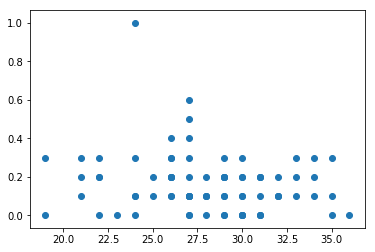

In [33]:
# Young players may tend to have the ball stripped from them
# more often - check visualization to confirm

plt.scatter(df_1.age, df_1.dispossessed)

#Seemingly no correlation between age and dispossessions

/Users/dgoldstein24/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


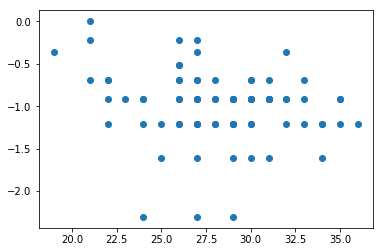

In [34]:
# Young players may tend to lose the ball more often - check visualization to confirm

plt.scatter(df_1.age, np.log(df_1.turnover))

#Seemingly no correlation between age and turnonvers

In [35]:
#check for signinficant correlation between age and all metrics

for metric in metrics:
    print(metric)
    print(stats.ttest_ind(df_1['age'], 
                    df_1[metric], equal_var = False))
    
#No significant correlation exists

assist
Ttest_indResult(statistic=66.16911306419999, pvalue=2.745075136895544e-72)
assistCorner
Ttest_indResult(statistic=66.2096097956021, pvalue=2.6745032036594376e-72)
assistCross
Ttest_indResult(statistic=66.20645381488555, pvalue=2.6791824510162824e-72)
assistFreekick
Ttest_indResult(statistic=66.2096097956021, pvalue=2.6745032036594376e-72)
assistOther
Ttest_indResult(statistic=66.17835639465525, pvalue=2.7268847789552026e-72)
assistThroughball
Ttest_indResult(statistic=66.20645381488555, pvalue=2.6791824510162824e-72)
assistThrowin
Ttest_indResult(statistic=66.2096097956021, pvalue=2.6745032036594376e-72)
challengeLost
Ttest_indResult(statistic=64.75036510862893, pvalue=2.5400816639754456e-72)
clearanceTotal
Ttest_indResult(statistic=54.61754463398858, pvalue=3.578225929275021e-72)
dispossessed
Ttest_indResult(statistic=65.76965734227086, pvalue=3.0417687675221625e-72)
dribbleLost
Ttest_indResult(statistic=66.03561619245735, pvalue=2.8139258472631043e-72)
dribbleTotal
Ttest_indRe

# No correlation between age and turnovers or dispossessions

# Create Radar Chart Visualization

In [37]:
#create df of top selections for Miami

cutoff = .35

df_1_filtered = df_1[(df_1['duelAerialPercentage_percentile'] > .33) & 
                         (df_1['tacklePercentage_percentile'] > cutoff) & 
                         (df_1['shortPassPercentage_percentile'] > cutoff) &
                         (df_1['turnover_percentile'] > cutoff) & 
                         (df_1['dispossessed_percentile'] > cutoff) &
                         (df_1['passLongBallPercentage_percentile'] > cutoff) 
                         
                        ]



top_10_Miami = df_1_filtered.sort_values(['top_percentile_average'], axis=0, ascending= False)[[
    'name', 'age', 'mins', 'team', 
    'duelAerialPercentage_percentile',
    'tacklePercentage_percentile',
    'shortPassPercentage_percentile',
    'turnover_percentile',
    'dispossessed_percentile',
    'passLongBallPercentage_percentile',
    'final_rating'
    
    
    
]].head(10)

In [38]:
top_10_Miami

,name,age,mins,team,duelAerialPercentage_percentile,tacklePercentage_percentile,shortPassPercentage_percentile,turnover_percentile,dispossessed_percentile,passLongBallPercentage_percentile,final_rating
27,Guram Kashia,32,1350,"San Jose Earthquakes,",0.402,0.378,0.720,0.598,0.768,0.854,100.000
60,Graham Smith,23,691,"Sporting Kansas City,",0.354,0.976,0.988,0.598,0.988,0.988,98.780
79,Matt Hedges,29,2435,"FC Dallas,",0.537,0.451,0.768,0.598,0.463,0.768,97.561
34,Maxime Chanot,29,2340,"New York City FC,",0.634,0.866,0.415,0.598,0.463,0.500,96.341
73,Chad Marshall,35,720,"Seattle Sounders FC,",0.732,0.768,0.854,0.854,0.988,0.976,95.122
68,Daniel Steres,28,1985,"LA Galaxy,",0.695,0.476,0.366,0.854,0.988,0.720,90.244
3,Gastón Sauro,29,1285,"Columbus Crew,",0.841,0.951,0.817,0.598,0.768,0.439,89.024
45,Lamine Sané,32,1890,"Orlando City,",0.537,0.768,0.683,0.854,0.768,0.817,84.146
50,Reto Ziegler,33,2250,"FC Dallas,",0.378,0.512,0.866,0.598,0.768,0.829,71.951
9,Eddie Segura,22,2414,"Los Angeles FC,",0.439,0.805,0.793,0.598,0.463,0.390,60.976


In [39]:
#Examine per90 stats on top selection

df_1[df_1.name == 'Daniel Steres '][['name','mins', 'age',
                                    'turnover', 
                                    'dispossessed', 
                                    'duelAerialPercentage',
                                    'tacklePercentage',
                                    'shortPassPercentage',
                                    
                                   
                                   
                                   ]]

,name,mins,age,turnover,dispossessed,duelAerialPercentage,tacklePercentage,shortPassPercentage
68,Daniel Steres,1985,28,0.3,0.0,0.644444,0.727273,0.895013


In [ ]:
#Examine percentile info on top selection

In [40]:
#Examine more info on top selection

df_1[df_1.name == 'Daniel Steres '][['name', 'final_rating',
                                    'turnover_percentile', 
                                    'dispossessed_percentile', 
                                    'duelAerialPercentage_percentile',
                                    'tacklePercentage_percentile',
                                    'shortPassPercentage_percentile',
                                    
                                   
                                   
                                   ]]

,name,final_rating,turnover_percentile,dispossessed_percentile,duelAerialPercentage_percentile,tacklePercentage_percentile,shortPassPercentage_percentile
68,Daniel Steres,90.244,0.854,0.988,0.695,0.476,0.366


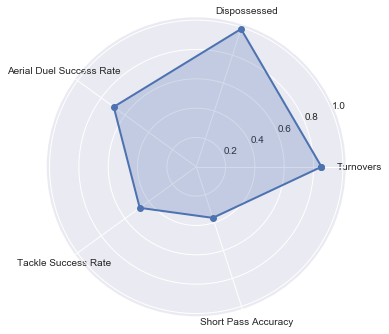

In [41]:
#Create radar graph for visualization of player percentile rankgins most relevant to
#Inter Miami CF


labels=np.array(['Turnovers','Dispossessed','Aerial Duel Success Rate', 'Tackle Success Rate', 'Short Pass Accuracy'])
selection = top_10_Miami[top_10_Miami.name == 'Daniel Steres ']
plt.style.use('seaborn')
stats= [float(list(selection['turnover_percentile'])[0]), 
        float(list(selection['dispossessed_percentile'])[0]),
        float(list(selection['duelAerialPercentage_percentile'])[0]),
        float(list(selection['tacklePercentage_percentile'])[0]),
        float(list(selection['shortPassPercentage_percentile'])[0])]
        

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# close the plot
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
#ax.set_title('Mikey Ambrose - FB - 25')
ax.grid(True)
        
        
        
        
        

# Create bar graph visualization to demonstrate CB overall ranking

In [42]:
#create df that isolates player ranking


df_ranked = df_1.sort_values(['top_percentile_average'], axis=0, ascending= False)[[
    'name', 
    'final_rating'
    
    
    
]]

#Select players with varied overall rankings and their respective rankings

graph_ids = ['Miles Robinson ', 'Laurent Ciman ', 'Michael Mancienne ', 'Josh Williams ', 'Robin Jansson ']
overall_graph = df_1[df_1['name'].isin(graph_ids)].sort_values(['final_rating'], ascending = False)

In [43]:
overall_graph['name']

57       Miles Robinson 
4         Laurent Ciman 
20    Michael Mancienne 
80        Josh Williams 
49        Robin Jansson 
Name: name, dtype: object

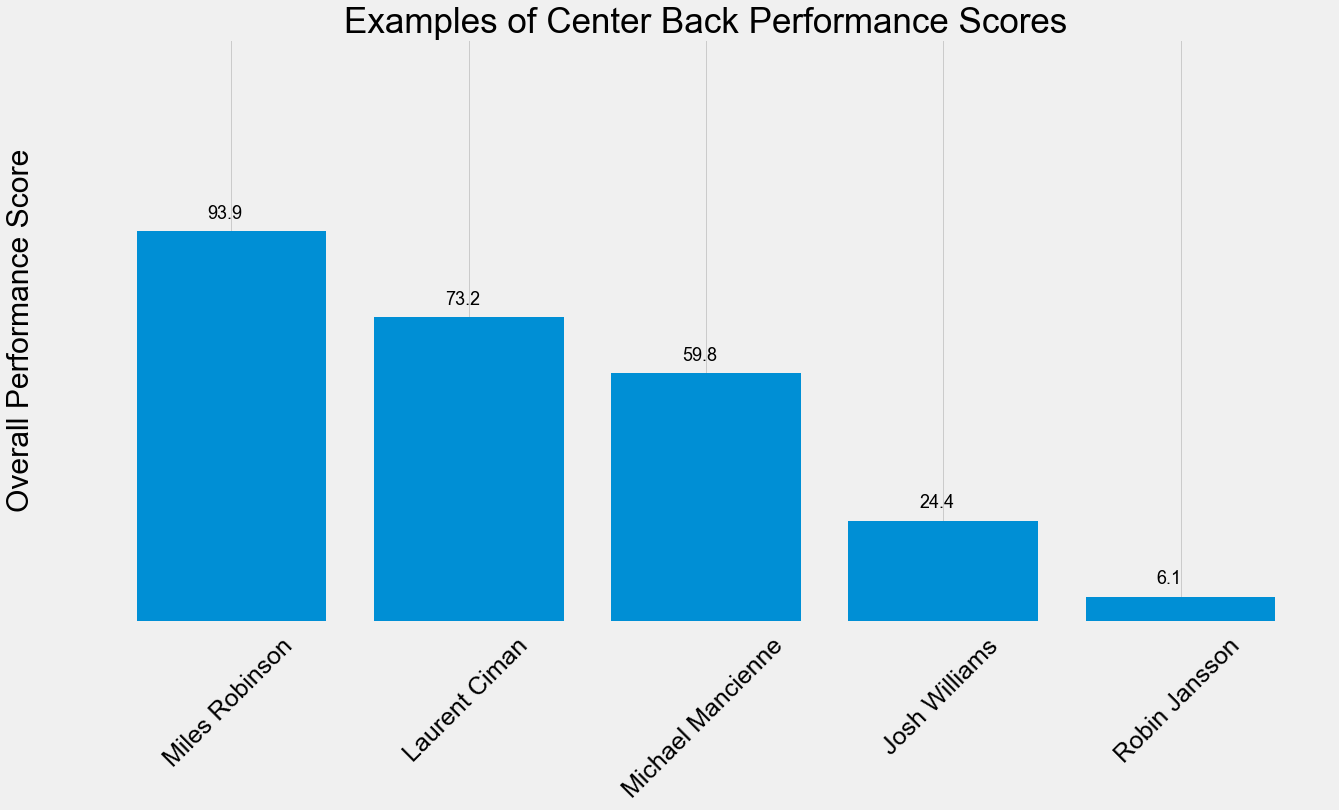

In [47]:
#Create bar graph


fig = plt.figure(figsize = (20, 10))
#fig.subplots_adjust(bottom = .5)
ax = fig.add_subplot(111)
import matplotlib.pyplot as plt # reset style
#plt.style.use('Solarize_Light2')
#plt.style.use('seaborn-paper')
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-paper')
ax.axes.set_ylim(0,140)
ax.bar(list(overall_graph['name']), list(round(overall_graph['final_rating'], 1)))
ax.set_ylabel('Overall Performance Score', size = 30, color = 'black')
#ax.spines['bottom'].set_color('black')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    tick.label.set_color('black')
    tick.label.set_rotation(45)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_color('black')

ax.set_title(label = 'Examples of Center Back Performance Scores',
             size = 35,
             color = 'black')
for i in range(len(list(ax.yaxis.get_major_ticks()))):
    ax.yaxis.get_major_ticks()[i].set_visible(False)
for patch in ax.patches:
    ax.text(patch.get_x() + .3, patch.get_height()+3, str(patch.get_height()), color = 'black', size = 18)

plt.show()